### Figure 5: Power Spectra at each wave number

In [2]:
import numpy as np
from esda.moran import Moran,Moran_Local
from libpysal.weights import lat2W
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import properscoring as ps
import warnings
from scipy import stats
import scipy.stats as stats
# from utils.evaluation import plot_histogram,calc_peak,calc_mean
from sklearn.metrics import mean_squared_error
from math import sqrt
import xesmf as xe
warnings.filterwarnings("ignore")
sns.set_style("white")
sns.set_palette(sns.color_palette("Paired"))

/user/work/al18709/.conda/envs/aquatic/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [3]:
def power_spectrum_dB(img):
	fx = np.fft.fft2(img)
	fx = fx[:img.shape[0]//2, :img.shape[1]//2] # disgard half of it because you can derive one half from the other?
	px = abs(fx)**2 # get the size of the amplitudes
	return 10 * np.log10(px) # is this the rainfall normalisation step?

def power_spectrum_dB_2(img):
	fx = np.fft.fft2(img)
	# fx = fx[:img.shape[0]//2, :img.shape[1]//2] # disgard half of it because you can derive one half from the other?
	px = abs(fx)**2 # get the size of the amplitudes
	return px

def log_spectral_batch(batch1):
	lsd_batch = []
	for i in range(batch1.shape[0]):
		lsd = power_spectrum_dB_2(
				batch1[i, :, :])
		lsd_batch.append(lsd)
	return np.array(lsd_batch)

In [4]:
model = ''
# set mode
mode = 'validation'

# load datasets
real = np.load('/user/home/al18709/work/dsrnngan_predictions%s/%s_real-opt.npy' % (model,mode))[0][:,:,:,0]
pred = np.load('/user/home/al18709/work/dsrnngan_predictions%s/%s_pred-opt.npy' % (model,mode))[0][:,:,:,0]

pred_cnn = np.load('/user/home/al18709/work/cnn/unet_valid.npy')
pred_dsrnngan = np.load('/user/home/al18709/work/dsrnngan_predictions/validation_pred-opt.npy')[0][:,:,:,0]
pred_vaegan = np.load('/user/home/al18709/work/vaegan/predictions/validation_pred.npy')[0][:,:,:,0]

pred_ensemble_vaegan = np.load('/user/home/al18709/work/vaegan/predictions/validation_pred.npy')[0]
pred_ensemble_gan = np.load('/user/home/al18709/work/dsrnngan_predictions%s/%s_pred-opt.npy' % (model,mode))[0]
inputs = np.load('/user/home/al18709/work/dsrnngan_predictions%s/%s_input-opt.npy' % (model,mode))[0][:,:,:,0]

# regrid inputs
grid_in = {"lon": np.linspace(0, 100, 10), "lat": np.linspace(0, 100, 10)}
grid_out = {"lon": np.linspace(0, 100, 100), "lat": np.linspace(0, 100, 100)}
regridder = xe.Regridder(grid_in, grid_out, "bilinear")
inputs_hr = regridder(inputs)

print(inputs_hr.shape)

(16253, 100, 100)


In [5]:
lsb_real = log_spectral_batch(real)
lsb_pred = log_spectral_batch(pred)
print(lsb_real[0])


[[4.72032655e+08 1.58421974e+08 2.66253097e+07 ... 1.20263204e+06
  2.66253097e+07 1.58421974e+08]
 [2.40175262e+08 6.52289195e+07 9.57818244e+06 ... 1.57526812e+06
  3.61432166e+07 1.60362629e+08]
 [4.41615797e+07 1.29207603e+07 1.68605298e+06 ... 1.82845145e+06
  1.86645984e+07 5.15798949e+07]
 ...
 [4.32820389e+06 5.79264914e+06 5.64426437e+06 ... 9.89387364e+05
  9.01646829e+05 1.55204394e+06]
 [4.41615797e+07 5.15798949e+07 1.86645984e+07 ... 4.62646142e+05
  1.68605298e+06 1.29207603e+07]
 [2.40175262e+08 1.60362629e+08 3.61432166e+07 ... 8.67204337e+05
  9.57818244e+06 6.52289195e+07]]


In [6]:
print(np.fft.fftfreq(3, d = 2))

[ 0.          0.16666667 -0.16666667]


[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49. -50. -49. -48. -47. -46. -45.
 -44. -43. -42. -41. -40. -39. -38. -37. -36. -35. -34. -33. -32. -31.
 -30. -29. -28. -27. -26. -25. -24. -23. -22. -21. -20. -19. -18. -17.
 -16. -15. -14. -13. -12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.
  -2.  -1.]


<function matplotlib.pyplot.show(close=None, block=None)>

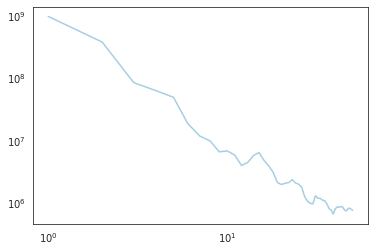

In [7]:
# https://bertvandenbroucke.netlify.app/2019/05/24/computing-a-power-spectrum-in-python/
npix=100
kfreq = np.fft.fftfreq(npix) * npix
# This will automatically return a one dimensional array containing the wave vectors for the numpy.fft.fftn call, in the correct order.
print(kfreq)
kfreq2D = np.meshgrid(kfreq, kfreq)
# To convert this to a two dimensional array matching the layout of the two dimensional Fourier image, we can use numpy.meshgrid

# Finally, we are not really interested in the actual wave vectors, but rather in their norm
knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)

# we no longer need the wave vector norms or Fourier image to be laid out as a two dimensional array, so we will flatten them
knrm = knrm.flatten()
fourier_amplitudes = lsb_real[0,:,:]
fourier_amplitudes = fourier_amplitudes.flatten()

# bin the amplitudes in k space, we need to set up wave number bins
# Note that the maximum wave number will equal half the pixel size of the image. 
# This is because half of the Fourier frequencies can be mapped back to negative wave
#  numbers that have the same norm as their positive counterpart.
kbins = np.arange(0.5, npix//2+1, 1.)

# The kbin array will contain the start and end points of all bins; the corresponding k values are the midpoints of these bins
kvals = 0.5 * (kbins[1:] + kbins[:-1])


# To compute the average Fourier amplitude (squared) in each bin, we can use scipy.stats
import scipy.stats as stats
Abins, _, _ = stats.binned_statistic(knrm, fourier_amplitudes,
                                     statistic = "mean",
                                     bins = kbins)

# Remember that we want the total variance within each bin. Right now, we only have the average power. To get the total power, we need to multiply with the volume in each bin (in 2D, this volume is actually a surface area)
Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)


plt.loglog(kvals, Abins)
plt.show


[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49. -50. -49. -48. -47. -46. -45.
 -44. -43. -42. -41. -40. -39. -38. -37. -36. -35. -34. -33. -32. -31.
 -30. -29. -28. -27. -26. -25. -24. -23. -22. -21. -20. -19. -18. -17.
 -16. -15. -14. -13. -12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.
  -2.  -1.]


<function matplotlib.pyplot.show(close=None, block=None)>

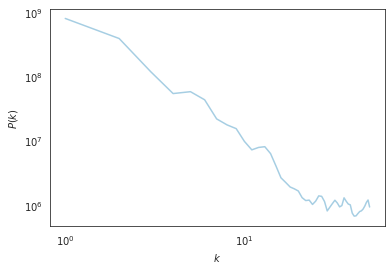

In [8]:
# https://bertvandenbroucke.netlify.app/2019/05/24/computing-a-power-spectrum-in-python/
npix=100
kfreq = np.fft.fftfreq(npix) * npix
# This will automatically return a one dimensional array containing the wave vectors for the numpy.fft.fftn call, in the correct order.
print(kfreq)
kfreq2D = np.meshgrid(kfreq, kfreq)
# To convert this to a two dimensional array matching the layout of the two dimensional Fourier image, we can use numpy.meshgrid

# Finally, we are not really interested in the actual wave vectors, but rather in their norm
knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)

# we no longer need the wave vector norms or Fourier image to be laid out as a two dimensional array, so we will flatten them
knrm = knrm.flatten()
fourier_amplitudes = lsb_pred[0,:,:]
fourier_amplitudes = fourier_amplitudes.flatten()

# bin the amplitudes in k space, we need to set up wave number bins
# Note that the maximum wave number will equal half the pixel size of the image. 
# This is because half of the Fourier frequencies can be mapped back to negative wave
#  numbers that have the same norm as their positive counterpart.
kbins = np.arange(0.5, npix//2+1, 1.)

# The kbin array will contain the start and end points of all bins; the corresponding k values are the midpoints of these bins
kvals = 0.5 * (kbins[1:] + kbins[:-1])


# To compute the average Fourier amplitude (squared) in each bin, we can use scipy.stats
import scipy.stats as stats
Abins, _, _ = stats.binned_statistic(knrm, fourier_amplitudes,
                                     statistic = "mean",
                                     bins = kbins)

# Remember that we want the total variance within each bin. Right now, we only have the average power. To get the total power, we need to multiply with the volume in each bin (in 2D, this volume is actually a surface area)
Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)


plt.loglog(kvals, Abins)
plt.xlabel("$k$")
plt.ylabel("$P(k)$")
plt.show


In [10]:
def plot_power_spectrum(spectral_density,plot=True):
    """
    spectral density should probably be a 100x100 image
    """
	# https://bertvandenbroucke.netlify.app/2019/05/24/computing-a-power-spectrum-in-python/
    npix=100

    # return a one dimensional array containing the wave vectors for the numpy.fft.fftn call, in the correct order.
    kfreq = np.fft.fftfreq(npix) * npix
    
    # convert this to a two dimensional array matching the layout of the two dimensional Fourier image, we can use numpy.meshgrid
    kfreq2D = np.meshgrid(kfreq, kfreq)
    
    # Finally, we are not really interested in the actual wave vectors, but rather in their norm
    knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)

    # we no longer need the wave vector norms or Fourier image to be laid out as a two dimensional array, so we will flatten them
    knrm = knrm.flatten()
    fourier_amplitudes = spectral_density
    fourier_amplitudes = fourier_amplitudes.flatten()

    # bin the amplitudes in k space, we need to set up wave number bins
    # Note that the maximum wave number will equal half the pixel size of the image. 
    # This is because half of the Fourier frequencies can be mapped back to negative wave
    #  numbers that have the same norm as their positive counterpart.
    kbins = np.arange(0.5, npix//2+1, 1.)

    # The kbin array will contain the start and end points of all bins; the corresponding k values are the midpoints of these bins
    kvals = 0.5 * (kbins[1:] + kbins[:-1])

    # To compute the average Fourier amplitude (squared) in each bin, we can use scipy.stats
    Abins, _, _ = stats.binned_statistic(knrm, fourier_amplitudes,
                                        statistic = "mean",
                                        bins = kbins)

    # Remember that we want the total variance within each bin. Right now, we only have the average power. To get the total power, we need to multiply with the volume in each bin (in 2D, this volume is actually a surface area)
    Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)

    if plot == True:
        plt.loglog(kvals, Abins)
        plt.show
    else:
        return kvals,Abins
    

In [12]:
kvals_list = []
Abins_list = []

for lsb in lsb_pred:
	kvals,Abins = plot_power_spectrum(lsb,plot=False)
	kvals_list.append(kvals)
	Abins_list.append(Abins)


In [14]:
kvals = np.array(kvals_list)
Abins = np.array(Abins_list)

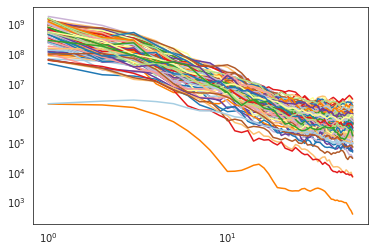

In [19]:
# print(kvals.shape)
# print(Abins.shape)
# print(Abins)

for i in range(len(kvals))[:100]:
	plt.loglog(kvals[i], Abins[i])

plt.show()